# <center>Рекомендательная система на основе эмбеддингов для датасета MovieLens</center>

# Модель на основе нейросети-трансформера

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Input, Model, layers, Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Подготовка датасета

In [3]:
movies_df = pd.read_csv(r"ml-latest\movies_mod.csv", index_col='movieId')
movies_df.head()

,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX,rating_mean,rating_std,rating_count
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,3.891454,0.917794,2469.0
2,Jumanji,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3.231282,0.959175,975.0
3,Grumpier Old Men,1995,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,3.190355,0.999860,591.0
4,Waiting to Exhale,1995,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,2.995902,1.031520,122.0
5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,3.032907,1.034132,547.0


In [4]:
ratings_df = pd.read_csv(r"ml-latest\ratings.csv").iloc[:100_000]
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [57]:
ratings_df = pd.merge(ratings_df, movies_df, how='left', left_on='movieId', right_on='movieId')
ratings_df = ratings_df.drop('title', axis=1)
ratings_df['rating'] = (ratings_df['rating'] - 0.5)/4.5

ratings_df.head()

,userId,movieId,rating,timestamp,features,is_valid,year,Action,Adventure,Animation,...,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX,rating_mean,rating_std,rating_count
0,1,307,0.037037,1256677221,"[1993.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",False,1993,0,0,0,...,0,0,0,0,0,0,0,4.036164,0.959485,318.0
1,1,481,0.037037,1256677456,"[1993.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",False,1993,0,0,0,...,0,0,1,0,0,0,0,3.371542,0.886573,253.0
2,1,1091,-0.061728,1256677471,"[1989.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....",False,1989,0,0,0,...,0,0,0,0,0,0,0,2.815421,1.122663,214.0
3,1,1257,0.086420,1256677460,"[1985.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....",False,1985,0,0,0,...,1,0,0,0,0,0,0,3.799550,0.921905,222.0
4,1,1449,0.086420,1256677264,"[1996.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....",False,1996,0,0,0,...,0,0,0,0,0,0,0,3.916667,0.974243,246.0


Объединение параметров в одну колонку

In [58]:
feature_list = ['year', 'Action', 'Adventure','Animation',"Children", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
               'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)', 'IMAX', 'rating_mean', 'rating_std', 'rating_count']

In [59]:
ratings_df['features'] = ratings_df[feature_list].values.tolist()
ratings_df['features']

0        [1993.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....
1        [1993.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....
2        [1989.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....
3        [1985.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....
4        [1996.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....
                               ...                        
99995    [1996.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....
99996    [1996.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1....
99997    [1971.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....
99998    [1996.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1....
99999    [1997.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1....
Name: features, Length: 100000, dtype: object

In [60]:
ratings_df.drop(feature_list, axis=1, inplace=True)

In [61]:
ratings_df.head()

,userId,movieId,rating,timestamp,features,is_valid
0,1,307,0.037037,1256677221,"[1993.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",False
1,1,481,0.037037,1256677456,"[1993.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",False
2,1,1091,-0.061728,1256677471,"[1989.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....",False
3,1,1257,0.086420,1256677460,"[1985.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....",False
4,1,1449,0.086420,1256677264,"[1996.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....",False


Разделим датасет на обучающую и валидационную выборку. Модель будет работать с последовательностями, поэтому для отложенной выборки нужно взять последние оценки пользователя

In [62]:
last_val = ratings_df.groupby('userId').filter(lambda x: len(x) > 0).sort_values('timestamp').groupby('userId').tail(1).sort_values('userId')
last_val.head()

,userId,movieId,rating,timestamp,features,is_valid
9,1,2840,0.012346,1256677500,"[1999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",True
18,2,1186,0.037037,1192913611,"[1989.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",True
36,3,1645,0.061728,945141611,"[1997.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",True
771,4,52950,0.086420,1204592934,"[2006.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",True
810,5,5995,0.111111,1209126093,"[2002.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",True


In [63]:
ratings_df['is_valid'] = False
ratings_df.loc[last_val.index, 'is_valid'] = True

In [64]:
ratings_df[ratings_df.is_valid]

,userId,movieId,rating,timestamp,features,is_valid
9,1,2840,0.012346,1256677500,"[1999.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",True
18,2,1186,0.037037,1192913611,"[1989.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",True
36,3,1645,0.061728,945141611,"[1997.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",True
771,4,52950,0.086420,1204592934,"[2006.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",True
810,5,5995,0.111111,1209126093,"[2002.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....",True
...,...,...,...,...,...,...
99362,1037,720,-0.111111,1320337890,"[1996.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0....",True
99382,1038,94,0.012346,851346977,"[1996.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1....",True
99446,1039,546,-0.037037,836021781,"[1993.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0....",True
99889,1040,143355,0.037037,1536475675,"[2017.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",True


In [65]:
grouped_ratings = ratings_df.sort_values(by='timestamp').groupby('userId').agg(tuple).reset_index()
grouped_ratings.head()

,userId,movieId,rating,timestamp,features,is_valid
0,1,"(3826, 307, 1590, 2478, 3698, 3020, 1449, 3424...","(-0.03703703703703704, 0.03703703703703703, -0...","(1256677210, 1256677221, 1256677236, 125667723...","([2000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","(False, False, False, False, False, False, Fal..."
1,2,"(1962, 849, 2108, 2746, 1244, 2915, 1663, 2352...","(0.0617283950617284, 0.03703703703703703, 0.03...","(1192913533, 1192913537, 1192913541, 119291354...","([1989.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1...","(False, False, False, False, False, False, Fal..."
2,3,"(1221, 960, 3171, 1321, 828, 640, 2028, 2024, ...","(0.0617283950617284, 0.012345679012345685, 0.0...","(945141407, 945141407, 945141407, 945141407, 9...","([1974.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1...","(False, False, False, False, False, False, Fal..."
3,4,"(2683, 2997, 786, 1527, 1923, 1584, 1610, 368,...","(0.03703703703703703, 0.0617283950617284, 0.06...","(1113765602, 1113765605, 1113765607, 111376561...","([1999.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0...","(False, False, False, False, False, False, Fal..."
4,5,"(1186, 2485, 728, 3178, 5528, 3173, 1147, 4839...","(-0.03703703703703704, 0.012345679012345685, 0...","(1209039308, 1209039342, 1209039379, 120903938...","([1989.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1...","(False, False, False, False, False, False, Fal..."


Сохраним количество рейтингов в последовательности

In [66]:
grouped_ratings['num_ratings'] = grouped_ratings['rating'].apply(lambda row: len(row))
grouped_ratings['num_ratings']

0        16
1        15
2        11
3       736
4        72
       ... 
1036     15
1037     12
1038     67
1039    468
1040     76
Name: num_ratings, Length: 1041, dtype: int64

Модель работает с последовательностями фиксированной длины, поэтому разобьём данные на последовательности фиксированной длины и получим всевозможные последовательности. Т.к. в некоторых последовательностях будут пропуски из-за того что их длина меньше фиксированной, нужно заполнить последовательности специальным токеном

In [67]:
# функция для создания последовательности
def create_sequences(values, col_name, sequence_length=10):
    sequences = []
    # Специальный токен обозначающий пустое место
    token = 0
    if col_name == 'features':
        token = [token]*24
    for i, v in enumerate(values):
        seq = values[:i+1]
        if len(seq) > sequence_length:
            seq = seq[i-sequence_length+1:i+1]
        elif len(seq) < sequence_length:
            seq =(*([token] * (sequence_length - len(seq))), *seq)
       
        sequences.append(seq)
    return sequences

In [68]:
grouped_cols = ['movieId', 'rating', 'timestamp', 'features', 'is_valid'] 
for col in grouped_cols:
    grouped_ratings[col] = grouped_ratings[col].apply(lambda x: create_sequences(x, col))

In [69]:
grouped_ratings.head()

,userId,movieId,rating,timestamp,features,is_valid,num_ratings
0,1,"[(0, 0, 0, 0, 0, 0, 0, 0, 0, 3826), (0, 0, 0, ...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, -0.03703703703703...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, 1256677210), (0, ...","[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, False), (0, 0, 0,...",16
1,2,"[(0, 0, 0, 0, 0, 0, 0, 0, 0, 1962), (0, 0, 0, ...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0.061728395061728...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, 1192913533), (0, ...","[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, False), (0, 0, 0,...",15
2,3,"[(0, 0, 0, 0, 0, 0, 0, 0, 0, 1221), (0, 0, 0, ...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0.061728395061728...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, 945141407), (0, 0...","[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, False), (0, 0, 0,...",11
3,4,"[(0, 0, 0, 0, 0, 0, 0, 0, 0, 2683), (0, 0, 0, ...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0.037037037037037...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, 1113765602), (0, ...","[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, False), (0, 0, 0,...",736
4,5,"[(0, 0, 0, 0, 0, 0, 0, 0, 0, 1186), (0, 0, 0, ...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, -0.03703703703703...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, 1209039308), (0, ...","[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[(0, 0, 0, 0, 0, 0, 0, 0, 0, False), (0, 0, 0,...",72


Разбиваем полученные последовательности на отдельрные строки и получаем датасет

In [70]:
exploded_ratings = grouped_ratings[['userId', 'movieId']].explode('movieId', ignore_index=True)
dfs = [grouped_ratings[[col]].explode(col, ignore_index=True) for col in grouped_cols[1:]]
seq_df = pd.concat([exploded_ratings, *dfs], axis=1)

In [71]:
seq_df.head()

,userId,movieId,rating,timestamp,features,is_valid
0,1,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 3826)","(0, 0, 0, 0, 0, 0, 0, 0, 0, -0.03703703703703704)","(0, 0, 0, 0, 0, 0, 0, 0, 0, 1256677210)","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(0, 0, 0, 0, 0, 0, 0, 0, 0, False)"
1,1,"(0, 0, 0, 0, 0, 0, 0, 0, 3826, 307)","(0, 0, 0, 0, 0, 0, 0, 0, -0.03703703703703704,...","(0, 0, 0, 0, 0, 0, 0, 0, 1256677210, 1256677221)","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(0, 0, 0, 0, 0, 0, 0, 0, False, False)"
2,1,"(0, 0, 0, 0, 0, 0, 0, 3826, 307, 1590)","(0, 0, 0, 0, 0, 0, 0, -0.03703703703703704, 0....","(0, 0, 0, 0, 0, 0, 0, 1256677210, 1256677221, ...","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(0, 0, 0, 0, 0, 0, 0, False, False, False)"
3,1,"(0, 0, 0, 0, 0, 0, 3826, 307, 1590, 2478)","(0, 0, 0, 0, 0, 0, -0.03703703703703704, 0.037...","(0, 0, 0, 0, 0, 0, 1256677210, 1256677221, 125...","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(0, 0, 0, 0, 0, 0, False, False, False, False)"
4,1,"(0, 0, 0, 0, 0, 3826, 307, 1590, 2478, 3698)","(0, 0, 0, 0, 0, -0.03703703703703704, 0.037037...","(0, 0, 0, 0, 0, 1256677210, 1256677221, 125667...","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(0, 0, 0, 0, 0, False, False, False, False, Fa..."


In [72]:
seq_df.is_valid

0                       (0, 0, 0, 0, 0, 0, 0, 0, 0, False)
1                   (0, 0, 0, 0, 0, 0, 0, 0, False, False)
2               (0, 0, 0, 0, 0, 0, 0, False, False, False)
3           (0, 0, 0, 0, 0, 0, False, False, False, False)
4        (0, 0, 0, 0, 0, False, False, False, False, Fa...
                               ...                        
99995    (False, False, False, False, False, False, Fal...
99996    (False, False, False, False, False, False, Fal...
99997    (False, False, False, False, False, False, Fal...
99998    (False, False, False, False, False, False, Fal...
99999    (False, False, False, False, False, False, Fal...
Name: is_valid, Length: 100000, dtype: object

В столбце *is_valid* списки лучше представить в виде одного значения. То, что запись относится к валидационной выборке, определяет последнее значение в списке (если *True* - то запись относится к отложенной выборке)

In [73]:
seq_df['is_valid'] = seq_df['is_valid'].apply(lambda x: x[-1])
seq_df[seq_df.is_valid]

,userId,movieId,rating,timestamp,features,is_valid
15,1,"(1449, 3424, 481, 1257, 2134, 1091, 1591, 3893...","(0.08641975308641975, 0.08641975308641975, 0.0...","(1256677264, 1256677444, 1256677456, 125667746...","([1996.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0...",True
30,2,"(2915, 1663, 2352, 170, 1235, 3363, 2707, 2243...","(0.03703703703703703, 0.012345679012345685, 0....","(1192913562, 1192913565, 1192913575, 119291358...","([1983.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0...",True
41,3,"(960, 3171, 1321, 828, 640, 2028, 2024, 1985, ...","(0.012345679012345685, 0.0617283950617284, 0.0...","(945141407, 945141407, 945141407, 945141610, 9...","([1946.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1...",True
777,4,"(3639, 481, 55765, 48774, 51935, 53972, 51662,...","(0.03703703703703703, 0.0617283950617284, 0.08...","(1204592829, 1204592835, 1204592840, 120459284...","([1974.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",True
849,5,"(54286, 8784, 30749, 40278, 858, 1193, 1213, 5...","(0.0617283950617284, 0.08641975308641975, 0.06...","(1209040142, 1209040159, 1209040167, 120904017...","([2007.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0...",True
...,...,...,...,...,...,...
99376,1037,"(1918, 2021, 2058, 2193, 3006, 1042, 1061, 272...","(-0.1111111111111111, -0.1111111111111111, -0....","(1320337876, 1320337877, 1320337878, 132033787...","([1998.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0...",True
99388,1038,"(62, 648, 141, 832, 58, 3, 708, 852, 86, 94)","(0.1111111111111111, 0.012345679012345685, 0.0...","(851346714, 851346714, 851346714, 851346799, 8...","([1995.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1...",True
99455,1039,"(552, 327, 338, 520, 491, 247, 419, 372, 502, ...","(0.012345679012345685, 0.012345679012345685, 0...","(836021254, 836021408, 836021431, 836021491, 8...","([1993.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0...",True
99923,1040,"(176101, 67197, 1342, 34048, 96857, 8870, 9005...","(0.012345679012345685, 0.0617283950617284, 0.0...","(1533791872, 1533826118, 1533833812, 153402376...","([2017.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0...",True


Для удобства будем хранить последний рейтинг из списка в колонке *target_rating*, а предыдущий список в колонке *previous_ratings*

In [74]:
seq_df['target_rating'] = seq_df['rating'].apply(lambda x: x[-1])
seq_df['previous_ratings'] = seq_df['rating'].apply(lambda x: x[:-1])
seq_df.drop('rating', axis=1, inplace=True)

Аналогично обрабатываем последовательность фильмов и их признаков

In [75]:
seq_df['target_movie'] = seq_df['movieId'].apply(lambda x: x[-1])
seq_df['previous_movies'] = seq_df['movieId'].apply(lambda x: x[:-1])
seq_df.drop(columns=['movieId'], inplace=True)

In [76]:
seq_df['target_movie_features'] = seq_df['features'].apply(lambda x: x[-1])
seq_df['previous_movies_features'] = seq_df['features'].apply(lambda x: x[:-1])
seq_df.drop(columns=['features'], inplace=True)

In [77]:
seq_df.head()

,userId,timestamp,is_valid,target_rating,previous_ratings,target_movie,previous_movies,target_movie_features,previous_movies_features
0,1,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 1256677210)",False,-0.037037,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",3826,"(0, 0, 0, 0, 0, 0, 0, 0, 0)","[2000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1,"(0, 0, 0, 0, 0, 0, 0, 0, 1256677210, 1256677221)",False,0.037037,"(0, 0, 0, 0, 0, 0, 0, 0, -0.03703703703703704)",307,"(0, 0, 0, 0, 0, 0, 0, 0, 3826)","[1993.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1,"(0, 0, 0, 0, 0, 0, 0, 1256677210, 1256677221, ...",False,-0.012346,"(0, 0, 0, 0, 0, 0, 0, -0.03703703703703704, 0....",1590,"(0, 0, 0, 0, 0, 0, 0, 3826, 307)","[1997.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1,"(0, 0, 0, 0, 0, 0, 1256677210, 1256677221, 125...",False,0.061728,"(0, 0, 0, 0, 0, 0, -0.03703703703703704, 0.037...",2478,"(0, 0, 0, 0, 0, 0, 3826, 307, 1590)","[1986.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1,"(0, 0, 0, 0, 0, 1256677210, 1256677221, 125667...",False,0.037037,"(0, 0, 0, 0, 0, -0.03703703703703704, 0.037037...",3698,"(0, 0, 0, 0, 0, 3826, 307, 1590, 2478)","[1987.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Чтобы модель не обучалась на токенах пропуска, нужно создать колонку с маской токена. Это бует список, показывающий является ли элемент токеном пропуска. Для удобства можно хранить количество пропусков в списке

In [78]:
seq_df['pad_mask'] = seq_df['timestamp'].apply(lambda x: [el == 0 for el in x])
seq_df['num_pads'] = seq_df['timestamp'].apply(lambda x: sum([1 if el == 0 else 0 for el in x]))

In [79]:
seq_df.head()

,userId,timestamp,is_valid,target_rating,previous_ratings,target_movie,previous_movies,target_movie_features,previous_movies_features,pad_mask,num_pads
0,1,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 1256677210)",False,-0.037037,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",3826,"(0, 0, 0, 0, 0, 0, 0, 0, 0)","[2000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[True, True, True, True, True, True, True, Tru...",9
1,1,"(0, 0, 0, 0, 0, 0, 0, 0, 1256677210, 1256677221)",False,0.037037,"(0, 0, 0, 0, 0, 0, 0, 0, -0.03703703703703704)",307,"(0, 0, 0, 0, 0, 0, 0, 0, 3826)","[1993.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[True, True, True, True, True, True, True, Tru...",8
2,1,"(0, 0, 0, 0, 0, 0, 0, 1256677210, 1256677221, ...",False,-0.012346,"(0, 0, 0, 0, 0, 0, 0, -0.03703703703703704, 0....",1590,"(0, 0, 0, 0, 0, 0, 0, 3826, 307)","[1997.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[True, True, True, True, True, True, True, Fal...",7
3,1,"(0, 0, 0, 0, 0, 0, 1256677210, 1256677221, 125...",False,0.061728,"(0, 0, 0, 0, 0, 0, -0.03703703703703704, 0.037...",2478,"(0, 0, 0, 0, 0, 0, 3826, 307, 1590)","[1986.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[True, True, True, True, True, True, False, Fa...",6
4,1,"(0, 0, 0, 0, 0, 1256677210, 1256677221, 125667...",False,0.037037,"(0, 0, 0, 0, 0, -0.03703703703703704, 0.037037...",3698,"(0, 0, 0, 0, 0, 3826, 307, 1590, 2478)","[1987.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[True, True, True, True, True, False, False, F...",5


Разбиваем выборку на тренировочную и отложенную

In [80]:
train = seq_df[seq_df.is_valid == False]
valid = seq_df[seq_df.is_valid == True]

Временно удалим из датасета последовательности с пропусками. Нужно настроить слои-маски в модели, тогда пропуски можно будет не убирать, модель просто не будет на них обучаться

In [101]:
train = train[train.pad_mask.apply(lambda x: not any(x))]
valid = valid[valid.pad_mask.apply(lambda x: not any(x))]

## Модель нейросети-трансформера

In [126]:
def transformer_model(num_users, num_movies, emb_size=64, seq_len=10, n_genres = 20, n_features = 4):
    # ввод данных и маски
    user_input = keras.Input(shape=(1,), name='user_id_input')
    target_movie_input = Input(name="target_movie_input", shape=(1,))
    seq_movie_input = Input(name="seq_movie_ids_input", shape=(seq_len-1,))
    seq_movie = layers.Masking()(seq_movie_input)
    movies_features_input = Input(shape=(seq_len-1, n_genres+n_features), name='movie_features_input')
    movies_features = layers.Masking()(movies_features_input)
    target_movie_features = Input(shape=(1, n_genres+n_features), name='target_movie_features_input')
    seq_ratings_input = Input(name="sequence_ratings", shape=(seq_len-1,))
    seq_ratings = layers.Masking()(seq_ratings_input)
    
    inputs = [user_input, target_movie_input, seq_movie_input, seq_ratings_input, movies_features_input, target_movie_features]
    
    # кодирование фильмов
#     movie_emb1 = layers.Embedding(output_dim=emb_size, input_dim=num_movies+1, name='movie_emb1')(seq_movie)
#     movie_concat1 = layers.Concatenate(axis=2, name='movie_concat1')([movie_emb1, movies_features])
#     movie_seq_emb = layers.Dense(emb_size, activation='relu', name='movie_vec1')(movie_concat1)
    
#     movie_emb2 = layers.Embedding(output_dim=emb_size, input_dim=num_movies+1, name='movie_emb2')(target_movie_input)
#     movie_concat2 = layers.Concatenate(axis=2, name='movie_concat2')([movie_emb2, target_movie_features])
#     target_movie_emb = layers.Dense(emb_size, activation='relu', name='movie_vec2')(movie_concat2)
    
    movie_emb = layers.Embedding(output_dim=emb_size, input_dim=num_movies+1, name='movie_emb')
    movie_mask = layers.Masking()
    movie_concat = layers.Concatenate(axis=2, name='movie_concat')
    movie_vec = layers.Dense(emb_size, activation='relu', name='movie_vec')
    
    def encode_movie(movieId, movie_features):
        emb = movie_emb(movieId)
        
        concat = movie_concat([emb, movie_features])
        return movie_vec(concat)
    
    movie_seq_emb = encode_movie(seq_movie, movies_features)
    target_movie_emb = encode_movie(target_movie_input, target_movie_features)
    
    # эмбеддинг позиции
    position_emb = layers.Embedding(output_dim=emb_size, input_dim=seq_len+1, name='position_emb')(tf.expand_dims(tf.range(0, seq_len-1, 1), 0))
    
    
    add_res = layers.Add(name='position_emb_plus_movie_seq_emb')([position_emb, movie_seq_emb])
    seq_ratings_shaped = tf.expand_dims(seq_ratings, -1)
    mult_res = layers.Multiply(name='add_res_multiply_ratiings_seq')([add_res, seq_ratings_shaped])
    
    encoded_transformer_features = []
    
    for encoded_movie in tf.unstack(mult_res, axis=1):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))

    encoded_transformer_features.append(target_movie_emb)
    
    encoded_transformer_features = layers.concatenate(encoded_transformer_features, axis=1, name='concat_transformer_features')
    
    
    user_emb = layers.Embedding(output_dim=emb_size, input_dim=num_users+1, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='user_emb_flatten')(user_emb)


    
    
    attention = layers.MultiHeadAttention(num_heads=3, 
                                          key_dim=encoded_transformer_features.shape[2], 
                                          dropout=0.2,
                                          name="attention")(encoded_transformer_features, encoded_transformer_features)
    attention_output = layers.Dropout(0.2, name="attention_dropuput")(attention)
    
    features = layers.Add(name='add_features')([encoded_transformer_features, attention_output])
    features_norm = layers.LayerNormalization(name='layer_normalization_x1')(features)
    features_relu = layers.LeakyReLU(name='leaky_relu_x2')(features_norm)
    features_dense = layers.Dense(features_relu.shape[-1], name='dense_x2')(features_relu)
    features_dropout = layers.Dropout(0.1, name='dropout_x2')(features_dense)
    
    transformer_features = layers.Add(name='transformer_features_add')([features_norm, features_dropout])
    transformer_features_norm = layers.LayerNormalization(name='transformer_features_normalization')(transformer_features)
    features_result = layers.Flatten(name='transformer_features_out')(transformer_features_norm)

    features_concat = layers.concatenate([features_result, layers.Reshape([user_vec.shape[-1]])(user_vec)])

    # полносвязные слои
    dense_1 = layers.Dense(256, name='fully_connected_1')(features_concat)
    norm_1 = layers.BatchNormalization(name='batch_norm_1')(dense_1)
    relu_1 = layers.LeakyReLU(name='leaky_relu_1')(norm_1)
    dropout_1 = layers.Dropout(0.2, name='dropout_1')(relu_1)
    
    dense_2 = layers.Dense(256, name='fully_connected_2')(dropout_1)
    norm_2 = layers.BatchNormalization(name='batch_norm_2')(dense_2)
    relu_2 = layers.LeakyReLU(name='leaky_relu_2')(norm_2)
    dropout_2 = layers.Dropout(0.2, name='dropout_2')(relu_2)

    output = layers.Dense(1, activation='sigmoid', name='output')(dropout_2)
    
    movie_model = Model(inputs=inputs[1:], outputs=features_result)
    user_model = Model(inputs=user_input, outputs=user_vec)
    model = Model(inputs=inputs, outputs=output)
    
    adam = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=adam, loss= 'mean_absolute_error', metrics=['mean_squared_error', 'mean_absolute_percentage_error'])
    return movie_model, user_model, model

In [127]:
movie_model, user_model, model = transformer_model(ratings_df.userId.nunique(), movies_df.index[-1])

**Полная схема модели**

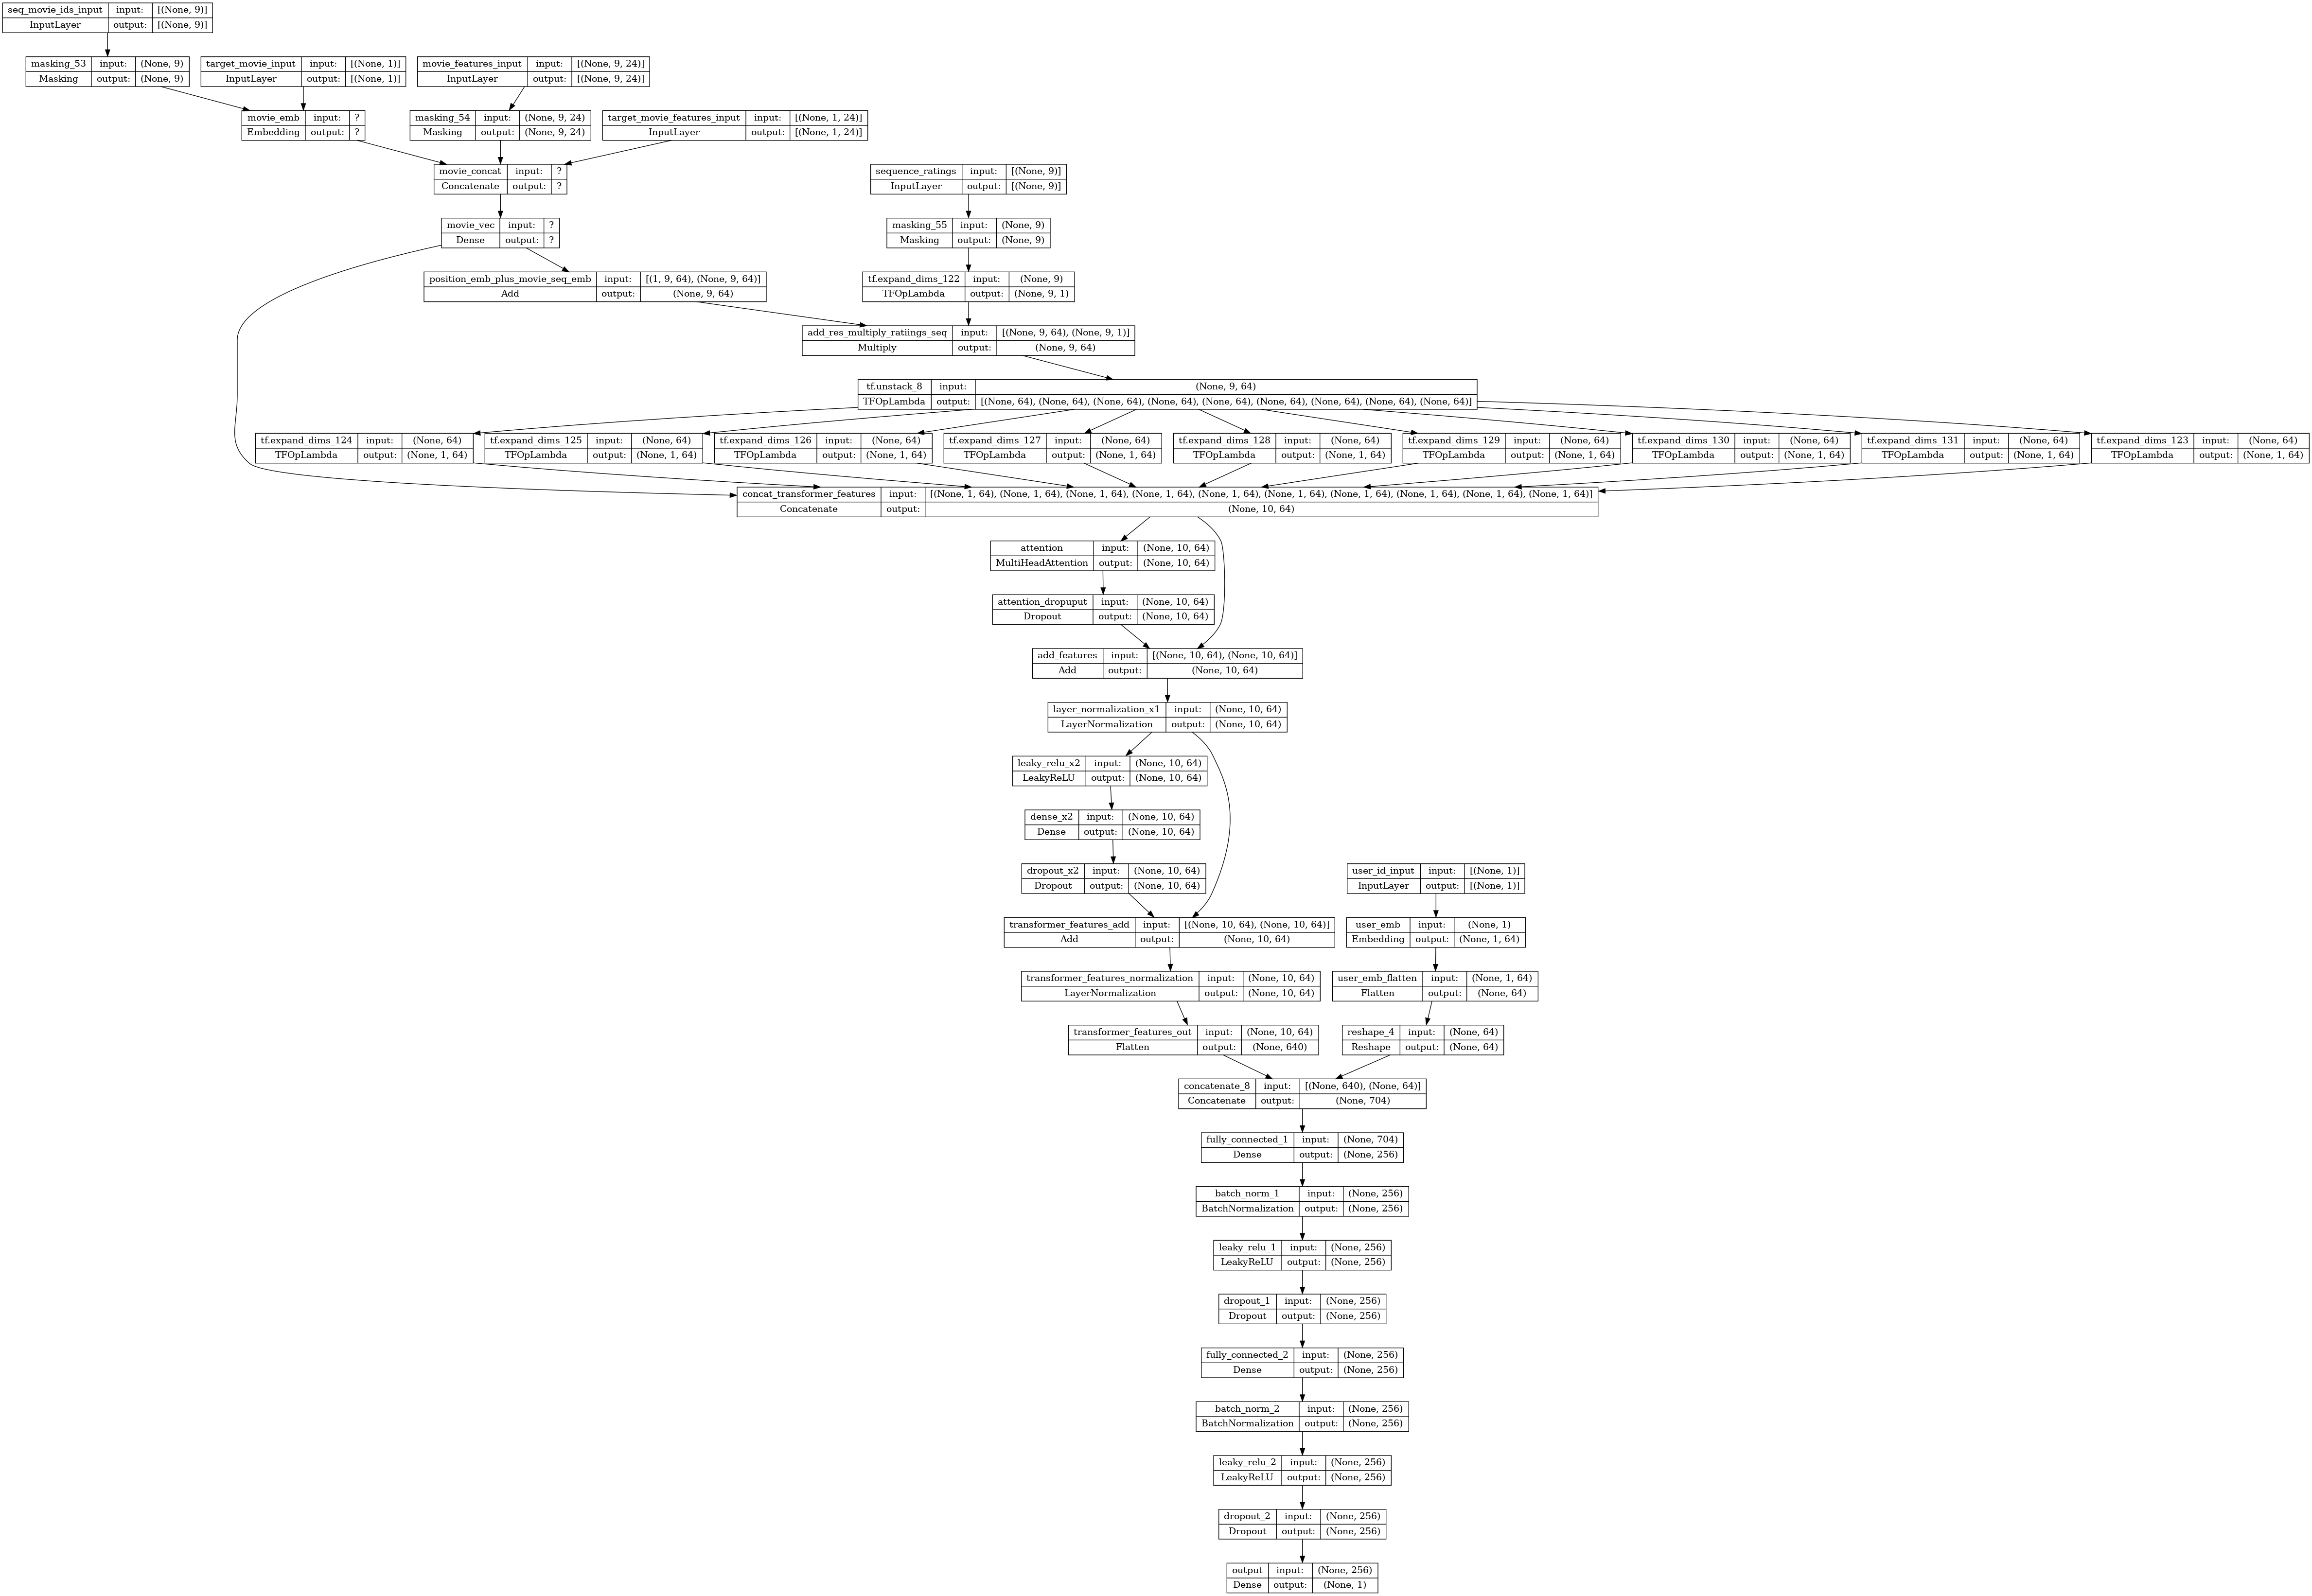

In [128]:
plot_model(model, show_shapes=True)

**Схема модели ч.1**

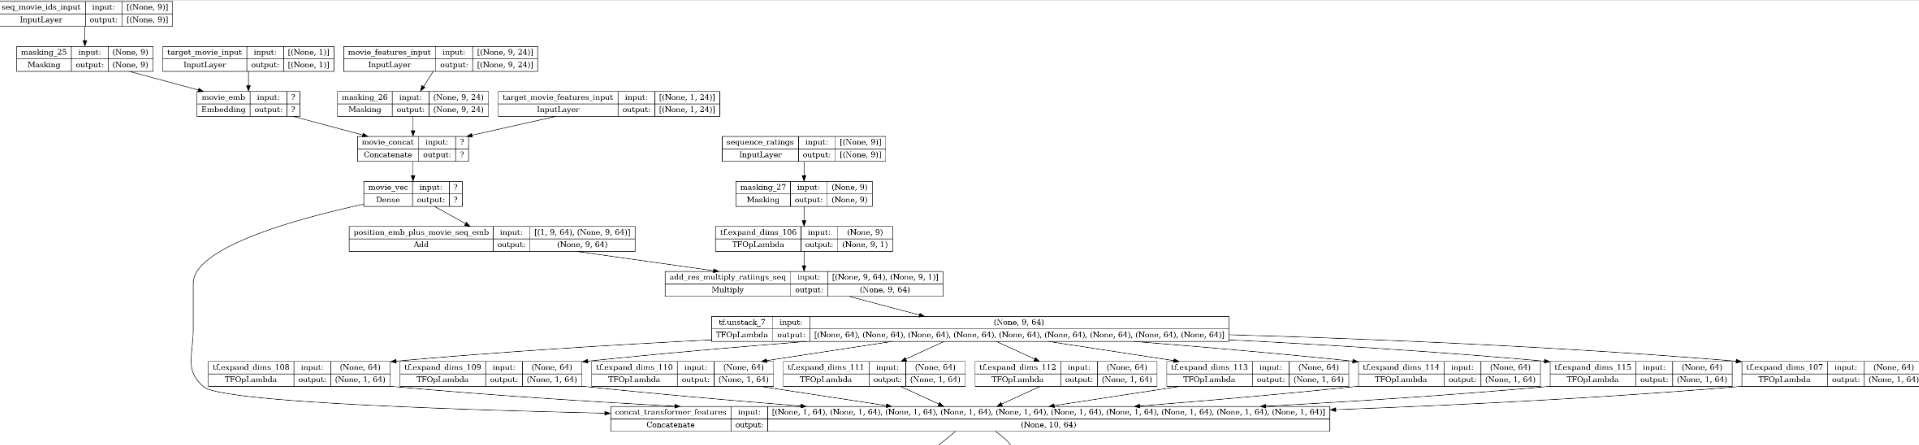

Модель получает на вход id фильма и пользователя, а также последовательность фильмов с рейтингами. Задача модели - предсказать рейтинг нового фильма.

Сначала модель создаёт эмбеддинги фильмов. Эмбединг объединяется с параметром и проходит через полносвязный слой для того, чтобы уменьшить размерность. Получается вектор фильма. Затем для всех фильмов кроме текущего создаётся эмбеддинг позиции, эмбеддинг позиции складывается c полученным вектором фильма, а затем умножается на рейтинг. К полученным векторам добавляется вектор текущего фильма (его не складывали с эмбеддингом позиции и не умножали на рейтинг), и эти вектора попадают в *MultiHeadAttention* слой.

**Схема модели ч.2**

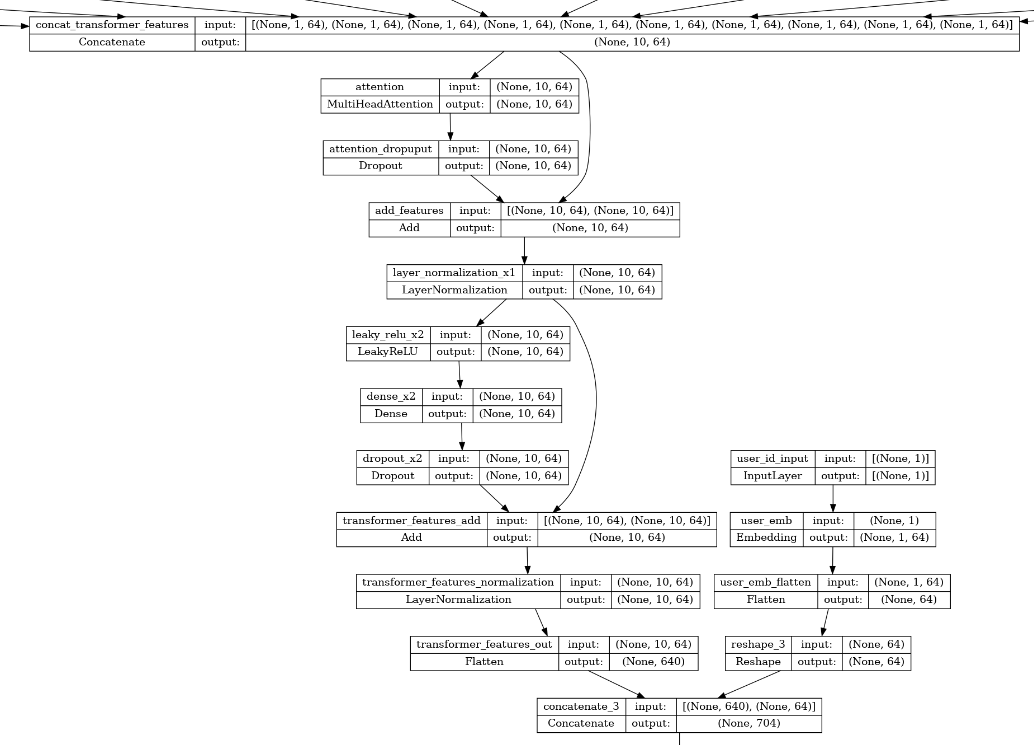

Полученный после attention слоя результат складывается с исходными вектрами - это вектор 1. Далее применяется полносвязный слой с нормализацией и дропаутом - это вектор 2. Вектора 1 и 2 складываются и нормализуются

**Схема модели ч.3**

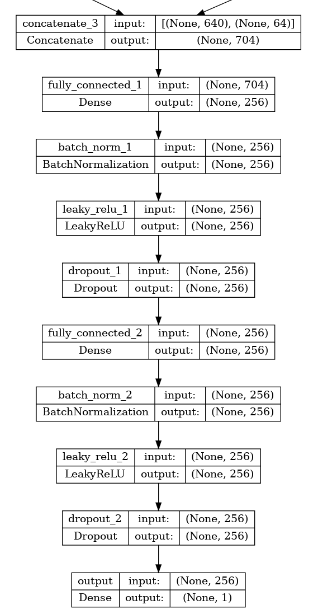
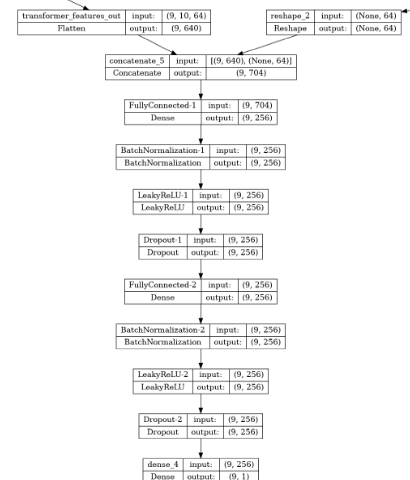

Результат работы соединяем с эмбеддингом пользователя, пропускаем через полносвязные слои с нормализацией и дропаутом. На выходе один нейрон с активацией сигмойдой

In [129]:
X_train  = [train.userId.values, 
            train.target_movie.values, 
            np.array(tuple(train['previous_movies'].values)), 
            np.array(tuple(train['previous_ratings'].values)), 
            np.array(list(train['previous_movies_features'].values)),
            np.array(list(train['target_movie_features'].values)).reshape((train.shape[0], 1, 24))
           ]

X_valid  = [valid.userId.values, 
            valid.target_movie.values, 
            np.array(tuple(valid['previous_movies'].values)), 
            np.array(tuple(valid['previous_ratings'].values)), 
            np.array(list(valid['previous_movies_features'].values)),
            np.array(list(valid['target_movie_features'].values)).reshape((valid.shape[0], 1, 24))
           ]

In [130]:
y_train = train.target_rating
y_valid = valid.target_rating

In [131]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('models/features/model/besttesttt.h5', save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=100,
                              epochs=5, validation_data=(X_valid, y_valid),
                              verbose=1,
                              callbacks = callbacks)

Epoch 1/5
905/905 [==============================] - 212s 228ms/step - loss: 0.0848 - mean_squared_error: 0.0182 - mean_absolute_percentage_error: 281.0031 - val_loss: 0.0417 - val_mean_squared_error: 0.0030 - val_mean_absolute_percentage_error: 129.0031
Epoch 2/5
905/905 [==============================] - 206s 228ms/step - loss: 0.0419 - mean_squared_error: 0.0029 - mean_absolute_percentage_error: 105.6124 - val_loss: 0.0383 - val_mean_squared_error: 0.0025 - val_mean_absolute_percentage_error: 97.3502
Epoch 3/5
905/905 [==============================] - 205s 226ms/step - loss: 0.0406 - mean_squared_error: 0.0027 - mean_absolute_percentage_error: 100.9547 - val_loss: 0.0380 - val_mean_squared_error: 0.0025 - val_mean_absolute_percentage_error: 101.7566
Epoch 4/5
905/905 [==============================] - 204s 225ms/step - loss: 0.0397 - mean_squared_error: 0.0026 - mean_absolute_percentage_error: 100.4010 - val_loss: 0.0385 - val_mean_squared_error: 0.0025 - val_mean_absolute_percenta

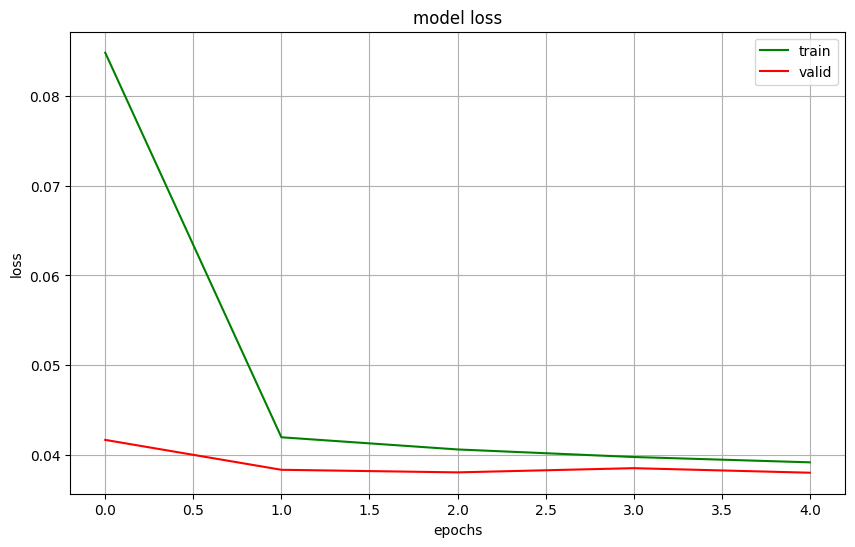

In [134]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper right')
plt.grid(True)
plt.show()

**Плюсы модели**
* Актуальная архитектура
* Возможность сильно минимизировать ошибку

**Минусы модели**
* Сложность архитектуры